<a href="https://colab.research.google.com/github/tmoura/bolsa/blob/master/acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Digite o código das Ações (ex: ITSA4,BBAS3):itsa4
['P/L', 'EV/EBITDA', 'P/VP', 'EV/EBIT', 'P/EBITDA', 'P/EBIT', 'VPA', 'P/Ativo', 'LPA', 'P/SR', 'P/Cap. Giro', 'P/Ativo Circ. Liq.', 'Dív. líquida/PL', 'Dív. líquida/EBITDA', 'Dív. líquida/EBIT', 'PL/Ativos', 'Passivo/Ativos', 'Liq. corrente', 'M. Bruta', 'M. EBITDA', 'M. EBIT', 'M. Líquida', 'ROE', 'ROA', 'ROIC', 'Giro ativos', 'CAGR Receitas 5 anos', 'CAGR Lucros 5 anos']


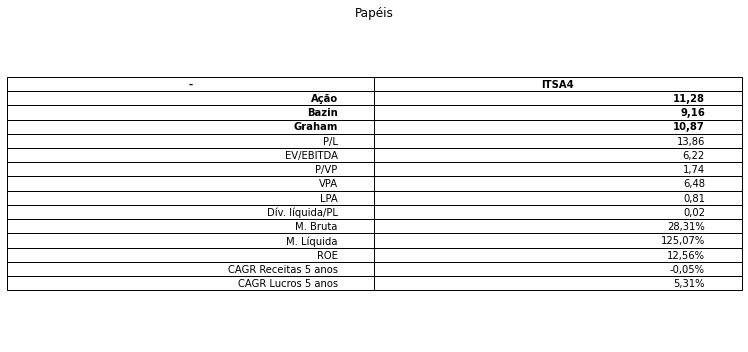

In [1]:
from lxml import html
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

entrada = input('Digite o código das Ações (ex: ITSA4,BBAS3):')
entrada = entrada.upper()

papeis = ['-']
papeis.extend(entrada.split(','))

indices = ['Ação','Bazin','Graham','P/L','EV/EBITDA','P/VP','VPA','LPA','Dív. líquida/PL','M. Bruta','M. Líquida','ROE','CAGR Receitas 5 anos','CAGR Lucros 5 anos']

url = 'https://statusinvest.com.br/acoes/'

exIndice = '//h3[@class="title m-0 uppercase"]/text()'
exIndice2 = '//h3[@class="title m-0 mr-1 uppercase"]/text()'
exTotal = exIndice + ' | ' + exIndice2

exValor = '//strong[@class="value d-block lh-4 fs-4 fw-700"]/text()'
exYield = '//div[@title="Dividend Yield com base nos últimos 12 meses"]/strong[@class="value"]/text()'
exAcao = '//div[@title="Valor atual do ativo"]/strong[@class="value"]/text()'

def processaPapeis(papeis, results):
    
    for i in range(1,len(papeis)):
        query = url + papeis[i]
        
        page = requests.get(query)

        tree = html.fromstring(page.content)

        vIndices = tree.xpath(exTotal)

        vResults = tree.xpath(exValor)
        
        vYield = tree.xpath(exYield)
        vYield = float(vYield[0].replace(',','.'))
        
        vAcao = tree.xpath(exAcao)[0]
        
        bazin = float(vAcao.replace(',','.')) * (vYield / 100) * 16.67

        temp = []

        for j in range(len(indices)):

            for k in range(len(vIndices)):
            
                if indices[j] == vIndices[k]:
                    temp.append(vResults[k])

                    if vIndices[k] == 'VPA':
                        vpa = float(vResults[k].replace(',','.'))
                    if vIndices[k] == 'LPA':
                        lpa = float(vResults[k].replace(',','.'))
                    break
        
        try:
            graham = math.sqrt(22.5 * vpa * lpa)
        except ValueError:
            print('Não conseguiu calcular Graham para o papel:',papeis[i])
            graham = 0
            
        temp.insert(0,'{:.2f}'.format(graham).replace('.',','))
        temp.insert(0,'{:.2f}'.format(bazin).replace('.',','))
        temp.insert(0,vAcao)
        results.append(temp)

    return results

rPapeis = []
rPapeis.append(indices)
rPapeis = processaPapeis(papeis, rPapeis)
rPapeis = list(map(list, zip(*rPapeis)))

#############
# Gerar Tabela de Dados
#############

#fig, ax = plt.subplots()
fig, ax1 = plt.subplots(figsize=(10.5,5))

# hide axes
fig.patch.set_visible(False)
ax1.axis('off')
ax1.axis('tight')
ax1.set_title('Papéis')

dfPapeis = pd.DataFrame(rPapeis, columns=papeis)

table = ax1.table(cellText=dfPapeis.values, colLabels=dfPapeis.columns, loc='center')

fig.tight_layout()

for (row, col), cell in table.get_celld().items():
  if (row in [0,1,2,3]):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))

plt.show()